In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import time
import torch.nn as nn

cuda = True

In [18]:
train = np.load("./data/loc_train_charged5.npy")

print(train.shape)
print(train[0][:][0][1].shape)

(1000, 49, 2, 5)
(5,)


(5, 2, 49)


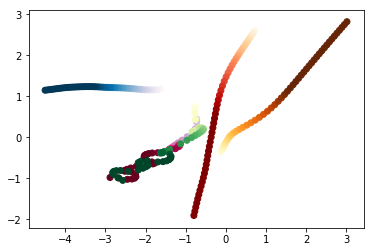

In [19]:
data = train[10]
data = np.transpose(data)
print(data.shape)
maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]
for part in range(5):
    cmap = maps[part](10*np.arange(49))
    plt.scatter(*data[part], c=cmap)

In [4]:
from utils import *
from modules import *

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    128, "_charged5")



In [5]:
def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)
        optimizer.zero_grad()

        logits = model.encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
        prob = my_softmax(logits, -1)

        if DECODER_TYPE == 'rnn':
            output = model.decoder(data, edges, rel_rec, rel_send, 100,
                             burn_in=True,
                             burn_in_steps=NUM_TIMESTEPS - PREDICTION_STEPS)
        else:
            output = model.decoder(data, edges, rel_rec, rel_send,
                             PREDICTION_STEPS)

        target = data[:, :, 1:, :]

        loss_nll = nll_gaussian(output, target, VAR)

        if PRIOR:
            loss_kl = kl_categorical(prob, log_prior, NUM_ATOMS)
        else:
            loss_kl = kl_categorical_uniform(prob, NUM_ATOMS,
                                             EDGE_TYPES)

        loss = loss_nll + loss_kl

        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)

        loss.backward()
        optimizer.step()

        mse_train.append(F.mse_loss(output, target).data[0])
        nll_train.append(loss_nll.data[0])
        kl_train.append(loss_kl.data[0])

    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []

    model.encoder.eval()
    model.decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        logits = model.encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)
        prob = my_softmax(logits, -1)

        # validation output uses teacher forcing
        output = model.decoder(data, edges, rel_rec, rel_send, 1)

        target = data[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).data[0])
        nll_val.append(loss_nll.data[0])
        kl_val.append(loss_kl.data[0])

    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(nll_train)),
          'kl_train: {:.10f}'.format(np.mean(kl_train)),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'acc_train: {:.10f}'.format(np.mean(acc_train)),
          'nll_val: {:.10f}'.format(np.mean(nll_val)),
          'kl_val: {:.10f}'.format(np.mean(kl_val)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'acc_val: {:.10f}'.format(np.mean(acc_val)),
          'time: {:.4f}s'.format(time.time() - t))
    
    return np.mean(nll_val)


def test():
    acc_test = []
    nll_test = []
    kl_test = []
    mse_test = []
    tot_mse = 0
    counter = 0

    model.encoder.eval()
    model.decoder.eval()
    model.encoder.load_state_dict(torch.load(encoder_file))
    model.decoder.load_state_dict(torch.load(decoder_file))
    for batch_idx, (data, relations) in enumerate(test_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        assert (data.size(2) - NUM_TIMESTEPS) >= NUM_TIMESTEPS

        data_model.encoder = data[:, :, :NUM_TIMESTEPS, :].contiguous()
        data_model.decoder = data[:, :, -NUM_TIMESTEPS:, :].contiguous()

        logits = model.encoder(data_model.encoder, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)

        prob = my_softmax(logits, -1)

        output = model.decoder(data_model.decoder, edges, rel_rec, rel_send, 1)

        target = data_model.decoder[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_test.append(acc)

        mse_test.append(F.mse_loss(output, target).data[0])
        nll_test.append(loss_nll.data[0])
        kl_test.append(loss_kl.data[0])

        # For plotting purposes
        if DECODER_TYPE == 'rnn':
            if args.dynamic_graph:
                output = model.decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS,
                                 dynamic_graph=True, encoder=model.encoder,
                                 temp=TAU)
            else:
                output = model.decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS)
            output = output[:, :, NUM_TIMESTEPS:, :]
            target = data[:, :, -NUM_TIMESTEPS:, :]
        else:
            data_plot = data[:, :, NUM_TIMESTEPS:NUM_TIMESTEPS + 21,
                        :].contiguous()
            output = model.decoder(data_plot, edges, rel_rec, rel_send, 20)
            target = data_plot[:, :, 1:, :]

        mse = ((target - output) ** 2).mean(dim=0).mean(dim=0).mean(dim=-1)
        tot_mse += mse.data.cpu().numpy()
        counter += 1

    mean_mse = tot_mse / counter
    mse_str = '['
    for mse_step in mean_mse[:-1]:
        mse_str += " {:.12f} ,".format(mse_step)
    mse_str += " {:.12f} ".format(mean_mse[-1])
    mse_str += ']'

    print('--------------------------------')
    print('--------Testing-----------------')
    print('--------------------------------')
    print('nll_test: {:.10f}'.format(np.mean(nll_test)),
          'kl_test: {:.10f}'.format(np.mean(kl_test)),
          'mse_test: {:.10f}'.format(np.mean(mse_test)),
          'acc_test: {:.10f}'.format(np.mean(acc_test)))
    print('MSE: {}'.format(mse_str))
    if args.save_folder:
        print('--------------------------------', file=log)
        print('--------Testing-----------------', file=log)
        print('--------------------------------', file=log)
        print('nll_test: {:.10f}'.format(np.mean(nll_test)),
              'kl_test: {:.10f}'.format(np.mean(kl_test)),
              'mse_test: {:.10f}'.format(np.mean(mse_test)),
              'acc_test: {:.10f}'.format(np.mean(acc_test)),
              file=log)
        print('MSE: {}'.format(mse_str), file=log)
        log.flush()

In [6]:
NUM_EPOCHS = 10
NUM_TIMESTEPS = 49 
dims = 4 
PREDICTION_STEPS = 10
VAR = 5e-5

PRIOR =False

SUFFIX = "_charged5"

TAU = Variable(torch.FloatTensor([0.5]), requires_grad=False).cuda()
HARD = False

NUM_ATOMS = 5
EDGE_TYPES = 2

DECODER_TYPE = "mlp"
# DECODER_TYPE = "mlp"
# DECODER_TYPE = "rnn"

DECODER_HIDDEN = 256
SKIP_FIRST = False
DECODER_DROPOUT = 0.0

off_diag = np.ones([NUM_ATOMS, NUM_ATOMS]) - np.eye(NUM_ATOMS)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()

In [7]:
# encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()

# decoder = MLPDecoder(n_in_node =4, n_hid = 256, edge_types=2, msg_hid = 256, msg_out=256).cuda()


class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()


        self.encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()
        
        if DECODER_TYPE == "mlp":
            self.decoder = MLPDecoder(n_in_node =4, n_hid = 256, edge_types=2, msg_hid = 256, msg_out=256).cuda()
        elif DECODER_TYPE == "sim":
            self.decoder = SimulationDecoder(loc_max, loc_min, vel_max, vel_min, SUFFIX).cuda()
        else:
            self.decoder = RNNDecoder(n_in_node=dims,
                         edge_types=EDGE_TYPES,
                         n_hid=DECODER_HIDDEN,
                         do_prob=DECODER_DROPOUT,
                         skip_first=SKIP_FIRST).cuda()
        

    def forward(self, x, tau=1, hard = False, n_samples = 1):

        logits = self.encoder(x, rel_rec, rel_send)
        output = []
        for i in range(n_samples):
            edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
            output.append(self.decoder(x, edges, rel_rec, rel_send,PREDICTION_STEPS))

        return output
    
model = GNN()
model

Using factor graph MLP encoder.
Using learned interaction net decoder.


/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:27: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:110: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


GNN(
  (encoder): MLPEncoder(
    (mlp1): MLP(
      (fc1): Linear(in_features=196, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (fc1): Linear(in_features=512, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp4): MLP(
      (fc1): Linear(in_features=768, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200,gamma=0.5)

In [9]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(NUM_EPOCHS):
    val_loss = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))



/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/utils.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWa

Epoch: 0000 nll_train: 48360.7421875000 kl_train: -1.1690802574 mse_train: 0.0251878873 acc_train: 0.5028958834 nll_val: 17979.2050781250 kl_val: -1.6040422916 mse_val: 0.0093641691 acc_val: 0.5000000000 time: 1.6391s
Epoch: 0001 nll_train: 31779.8378906250 kl_train: -0.6849777699 mse_train: 0.0165519994 acc_train: 0.4993840144 nll_val: 17496.9160156250 kl_val: -0.9801311493 mse_val: 0.0091129784 acc_val: 0.4990000000 time: 1.5228s
Epoch: 0002 nll_train: 27842.0742187500 kl_train: -0.6231748462 mse_train: 0.0145010790 acc_train: 0.4933969351 nll_val: 17128.0292968750 kl_val: -0.8196893930 mse_val: 0.0089208484 acc_val: 0.4885000000 time: 1.5597s
Epoch: 0003 nll_train: 25109.0742187500 kl_train: -0.6122810841 mse_train: 0.0130776428 acc_train: 0.4900916466 nll_val: 16851.6718750000 kl_val: -0.7130458355 mse_val: 0.0087769106 acc_val: 0.4815000000 time: 1.4883s
Epoch: 0004 nll_train: 23442.9414062500 kl_train: -0.5983047485 mse_train: 0.0122098653 acc_train: 0.4886530950 nll_val: 16638.2

torch.Size([5, 5, 99, 4])


RuntimeError: size mismatch, m1: [25 x 396], m2: [196 x 256] at /opt/conda/conda-bld/pytorch_1535493744281/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

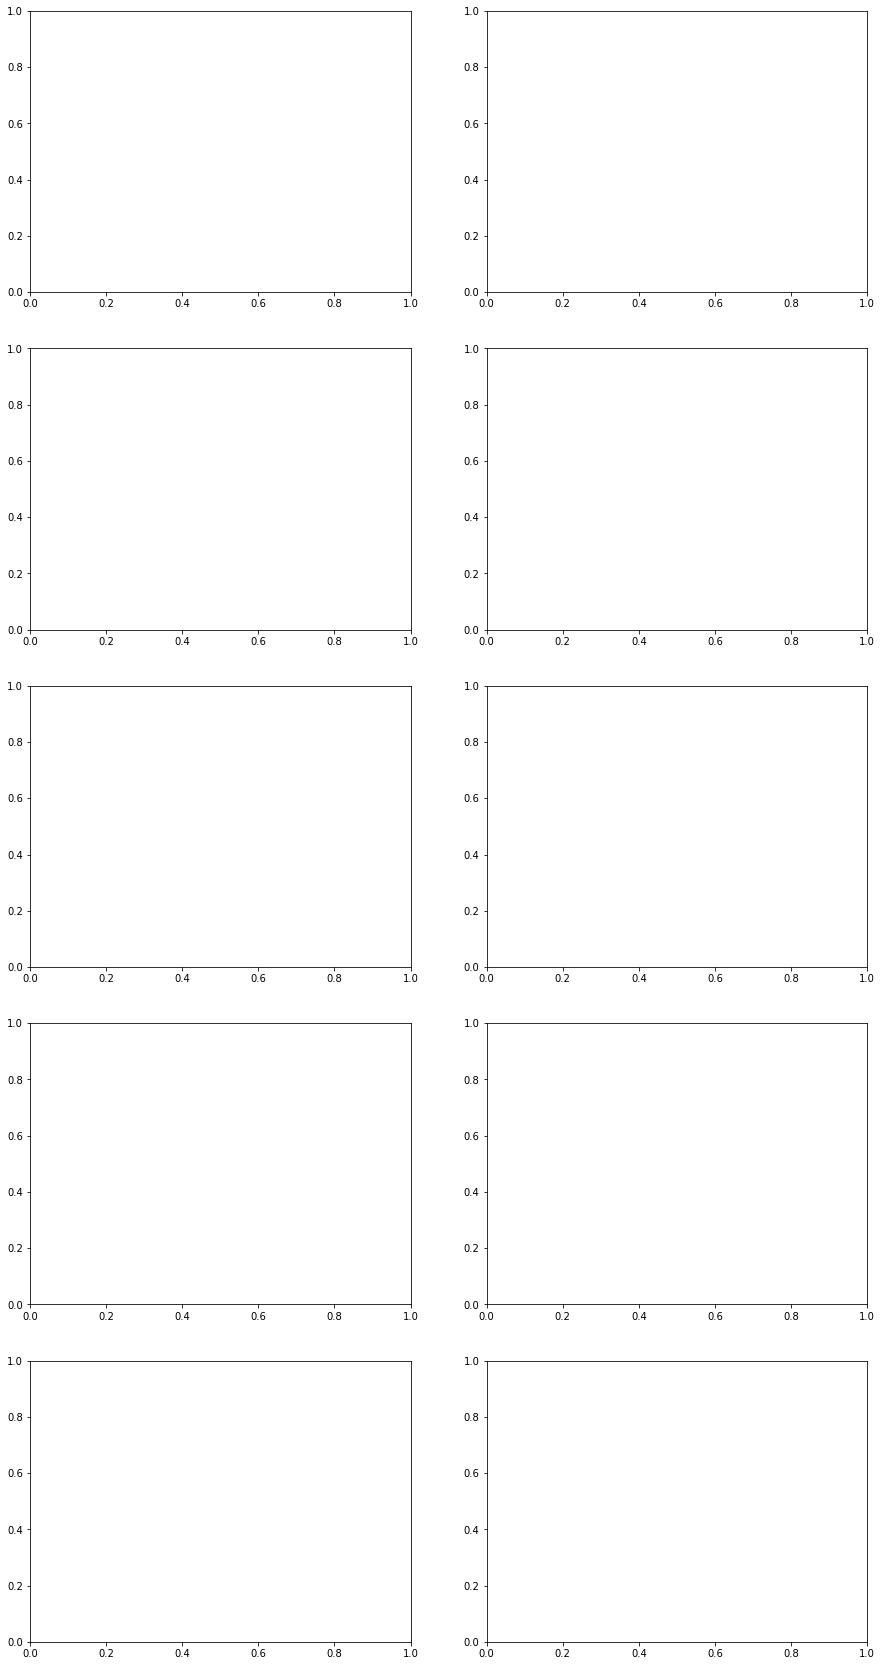

In [20]:
f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][0:5]
print(batch.shape)
reconstruction = model(batch.cuda(), n_samples = 20)

# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']

for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
#             cmap = maps[j](10*np.arange(49))
#             cmap = maps[j]
#             ax.scatter(b[j][0], b[j][1], c=cmap, alpha=1)
            ax.scatter(b[j][0], b[j][1], c=cmap)
#             ax.axis("off")
    else:
        for r in reconstruction:
            b = torch.transpose(r[i//2], 1,2).cpu().detach().numpy()
    #         print(b.shape)
            for j in range(5):
#                 cmap = maps[j](10*np.arange(48))
                cmap = maps[j]
#                 ax.scatter(b[j][0], b[j][1], c=cmap)
                ax.scatter(b[j][0], b[j][1], c=cmap, alpha = 0.05)
    #             ax.axis("off")


    